# PADS Web-scraping

- Viviane Sanchez (vivianecs2@al.insper.edu.br)

<table align="right">
    <tr>
        <td>
            <img src= "https://www.cftc.gov/sites/all/themes/cftc/images/Final-CFTC-Logo-Long.png"/>
        </td>
    </tr>
</table>


### Insper - Computação para Ciência de Dados

Análise dos dados divulgados semanalmente pela Comissão de Trading de Futuros de Commodities [(CFTC)](https://www.cftc.gov) do governo Americano.

### Conteúdo
 [1. Introdução](#1.-Introdução)
 
 [2. Bases de dados](#2.-Bases-de-dados)
 
 [3. Análise Gráfica](#3.-Análise-Gráfica)
 
 [4. Conclusão](#4.-Conclusão)

## 1. Introdução 

Toda semana, o governo americano divulga os dados consolidados da posição dos investidores nas bolsas para diferentes commodities através do relatório Commitment of Traders (ou ["COT"](https://www.cftc.gov/MarketReports/CommitmentsofTraders/index.htm)). Esses números ajudam o público a entender a dinâmica dos mercados através da análise da posição em aberto de futuros e opções.

## 2. Bases de dados

O relatório Commitment of Traders é divulgado toda sexta, com dados referentes à terça anterior, de duas formas:

1. Arquivo semanal, com a descrição da posição para cada ativo: [CFTC CIT - Commodity Index Trader Supplement](https://www.cftc.gov/dea/options/deaviewcit.htm)

2. Arquivos com o histórico consolidado: [CFTC Historical](https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalCompressed/index.htm)

A análise será feita na base do item 2, que possui informações mais completas.

In [5]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import datetime as dt
import wget
import zipfile
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt 
import squarify
%matplotlib inline

### 2.1. Base Consolidada

#### 2.1.1. Funções para baixar e tratar a base

As funções foram feitas para o caso de o usuário querer baixar e juntar arquivos de anos anteriores

In [3]:
#Função para abrir o zip e ler o txt
def abre_zip(arquivo_zip):
    zip = zipfile.ZipFile(arquivo_zip)
    arquivo = zip.namelist()
    with zip.open(arquivo[0],'r') as raw:
        txtb = raw.read()
    txt = str(txtb, encoding = 'utf-8').replace('"','').split('\r\n')
    base = []
    for line in txt:
        base.append(line.split(','))
    return base

In [2]:
#conta quantas colunas tem em cada linha na base e adiciona itens na primeira linha até ficar igual
def arruma_colunas(base):
    colunas = len(base[0])
    linhas = []
    for line in base:
        linhas.append(len(line))
    maximo = max(linhas)
    add = maximo - colunas
    if add != 0:
        while colunas < maximo:
            base[0].append('x')
            colunas = len(base[0])
    return base

In [8]:
def arruma_base(base):
    
    #transforma base txt em pandas DataFrame
    df = pd.DataFrame(data = base[1:], columns = base[0])
    df = df.apply(pd.to_numeric, errors='ignore')
    
    #Cria nova coluna com data
    df['date'] = pd.to_datetime(df['As_of_Date_In_Form_YYYY-MM-DD'], format='%Y-%m-%d')
    
    #remove colunas de data duplicadas e mantém a data ajustada
    df.drop('As_of_Date_In_Form_YYMMDD', axis = 1, inplace = True)
    df.drop('As_of_Date_In_Form_YYYY-MM-DD', axis = 1, inplace = True)
    
    #cria colunas com nome da commodity e da bolsa
    df['Commodity'] = df['Market_and_Exchange_Names'].str.split(' - ', n = 2, expand = True)[0]
    df['Exchange'] = df['Market_and_Exchange_Names'].str.split(' - ', n = 2, expand = True)[1]
    
    df.dropna(inplace = True)
    
    return df

#### 2.2.2. Download e limpeza da base consolidada de 2020

In [9]:
dwnld = wget.download('https://www.cftc.gov/files/dea/history/dea_cit_txt_2020.zip')
#wget.download(https://www.cftc.gov/files/dea/history/dea_cit_xls_2020.zip)

In [10]:
zip = zipfile.ZipFile(dwnld)

In [11]:
zip.filelist

[<ZipInfo filename='annualci.txt' compress_type=deflate file_size=80229 compress_size=22936>]

In [12]:
zp = zip.namelist()

In [13]:
with zip.open(zp[0],'r') as raw:
    txtb = raw.read() #Carrega o arquivo todo na memória

In [14]:
txtb

b'"Market_and_Exchange_Names","As_of_Date_In_Form_YYMMDD","As_of_Date_In_Form_YYYY-MM-DD","CFTC_Contract_Market_Code","CFTC_Market_Code","CFTC_Region_Code","CFTC_Commodity_Code","Open_Interest_All","NComm_Positions_Long_All_NoCIT","NComm_Positions_Short_All_NoCIT","NComm_Postions_Spread_All_NoCIT","Comm_Positions_Long_All_NoCIT","Comm_Positions_Short_All_NoCIT","Tot_Rept_Positions_Long_All","Tot_Rept_Positions_Short_All","NonRept_Positions_Long_All","NonRept_Positions_Short_All","CIT_Positions_Long_All","CIT_Positions_Short_All","Change_Open_Interest_All","Change_NonComm_Long_All_NoCIT","Change_NonComm_Short_All_NoCIT","Change_NonComm_Spead_All_NoCIT","Change_Comm_Long_All_NoCIT","Change_Comm_Short_All_NoCIT ","Change_Tot_Rept_Long_All","Change_Tot_Rept_Short_All","Change_NonRept_Long_All","Change_NonRept_Short_All","Change_CIT_Long_All","Change_CIT_Short_All","Pct_Open_Interest_All","Pct_OI_NonComm_Long_All_NoCIT","Pct_OI_NonComm_Short_All_NoCIT","Pct_OI_NonComm_Spread_All_NoCIT","Pct

In [15]:
txt = str(txtb, encoding = 'utf-8').replace('"','').split('\r\n')

In [16]:
cftc = []
for line in txt:
    cftc.append(line.split(','))

In [17]:
base = arruma_colunas(cftc)

In [18]:
df = arruma_base(base)

In [19]:
df.head()

,Market_and_Exchange_Names,CFTC_Contract_Market_Code,CFTC_Market_Code,CFTC_Region_Code,CFTC_Commodity_Code,Open_Interest_All,NComm_Positions_Long_All_NoCIT,NComm_Positions_Short_All_NoCIT,NComm_Postions_Spread_All_NoCIT,Comm_Positions_Long_All_NoCIT,...,Traders_Comm_Short_All_NoCIT,Traders_Tot_Rept_Long_All,Traders_Tot_Rept_Short_All,Traders_CIT_Long_All,Traders_CIT_Short_All,Contract_Units,x,date,Commodity,Exchange
0,WHEAT-SRW - CHICAGO BOARD OF TRADE,1602.0,CBT,0.0,1.0,495295.0,46217.0,51962.0,197349.0,64206.0,...,104.0,265.0,268.0,47.0,24.0,(CONTRACTS OF 5,000 BUSHELS),2020-03-24,WHEAT-SRW,CHICAGO BOARD OF TRADE
1,WHEAT-SRW - CHICAGO BOARD OF TRADE,1602.0,CBT,0.0,1.0,519290.0,42820.0,72883.0,210441.0,65998.0,...,108.0,283.0,299.0,50.0,25.0,(CONTRACTS OF 5,000 BUSHELS),2020-03-17,WHEAT-SRW,CHICAGO BOARD OF TRADE
2,WHEAT-SRW - CHICAGO BOARD OF TRADE,1602.0,CBT,0.0,1.0,546604.0,70906.0,78287.0,207910.0,61881.0,...,112.0,294.0,306.0,51.0,24.0,(CONTRACTS OF 5,000 BUSHELS),2020-03-10,WHEAT-SRW,CHICAGO BOARD OF TRADE
3,WHEAT-SRW - CHICAGO BOARD OF TRADE,1602.0,CBT,0.0,1.0,533295.0,71410.0,81711.0,197477.0,61430.0,...,114.0,299.0,298.0,53.0,23.0,(CONTRACTS OF 5,000 BUSHELS),2020-03-03,WHEAT-SRW,CHICAGO BOARD OF TRADE
4,WHEAT-SRW - CHICAGO BOARD OF TRADE,1602.0,CBT,0.0,1.0,557399.0,104653.0,93209.0,199107.0,58718.0,...,116.0,303.0,318.0,53.0,22.0,(CONTRACTS OF 5,000 BUSHELS),2020-02-25,WHEAT-SRW,CHICAGO BOARD OF TRADE


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 0 to 155
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Market_and_Exchange_Names         132 non-null    object        
 1   CFTC_Contract_Market_Code         132 non-null    float64       
 2   CFTC_Market_Code                  132 non-null    object        
 3   CFTC_Region_Code                  132 non-null    float64       
 4   CFTC_Commodity_Code               132 non-null    float64       
 5   Open_Interest_All                 132 non-null    float64       
 6   NComm_Positions_Long_All_NoCIT    132 non-null    float64       
 7   NComm_Positions_Short_All_NoCIT   132 non-null    float64       
 8   NComm_Postions_Spread_All_NoCIT   132 non-null    float64       
 9   Comm_Positions_Long_All_NoCIT     132 non-null    float64       
 10  Comm_Positions_Short_All_NoCIT    132 non-null    

### 3. Análise Gráfica

#### 3.1. Open Interest

O Open interest (contratos em aberto), é o número de negócios realizados para um determinado futuro.
Esse número mostra o interesse do mercado em operar o ativo, e é o consolidado de todos os vencimentos de futuros e opções que estão sendo operados na bolsa.

In [20]:
last_update = df['date'].max() #data da última atualização

In [21]:
df['Commodity'].unique().tolist()

['WHEAT-SRW',
 'WHEAT-HRW',
 'CORN',
 'SOYBEANS',
 'SOYBEAN OIL',
 'COTTON NO. 2',
 'LEAN HOGS',
 'LIVE CATTLE',
 'FEEDER CATTLE',
 'SUGAR NO. 11',
 'COFFEE C']

In [22]:
open_interest = df.loc[:,['Open_Interest_All','Change_Open_Interest_All','Commodity','CFTC_Market_Code']][df['date'] == last_update]

In [23]:
open_interest.sort_values(['Change_Open_Interest_All'], ascending=False, inplace = True)
open_interest

,Open_Interest_All,Change_Open_Interest_All,Commodity,CFTC_Market_Code
144,334638.0,-1068.0,COFFEE C,ICUS
72,262858.0,-4182.0,COTTON NO. 2,ICUS
108,49331.0,-6100.0,FEEDER CATTLE,CME
48,511224.0,-8778.0,SOYBEAN OIL,CBT
132,1255442.0,-17072.0,SUGAR NO. 11,ICUS
0,495295.0,-23996.0,WHEAT-SRW,CBT
36,960687.0,-25117.0,SOYBEANS,CBT
12,252977.0,-28490.0,WHEAT-HRW,CBT
96,357528.0,-29530.0,LIVE CATTLE,CME
24,1747679.0,-34094.0,CORN,CBT


#### 3.1.1 Open Interest por Commodity

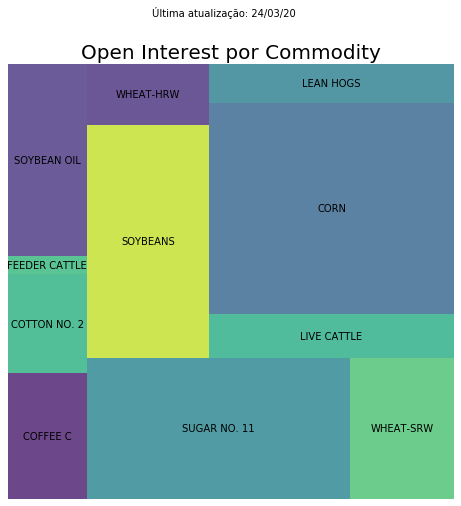

In [62]:
plt.figure(figsize=(8, 8))

squarify.plot(sizes=open_interest['Open_Interest_All'], 
              label=open_interest['Commodity'], 
              alpha=.8) 

plt.title('Open Interest por Commodity', fontsize = 20)
plt.suptitle('Última atualização: ' + str(last_update.strftime('%d/%m/%y')), fontsize = 10)
plt.axis('off') 
plt.show() 

#### 3.1.2. Concentração do Open interest por bolsa

In [63]:
bolsas = open_interest.groupby('CFTC_Market_Code').sum()

In [64]:
bolsas.index

Index(['CBT ', 'CME ', 'ICUS'], dtype='object', name='CFTC_Market_Code')

Text(0.5, 0.98, 'Última atualização: 24/03/20')

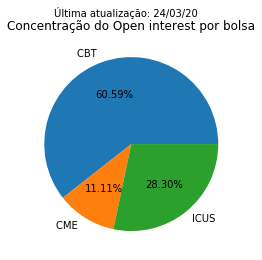

In [65]:
plt.pie(bolsas['Open_Interest_All'], autopct = "%.2f%%", labels = bolsas.index)
plt.title('Concentração do Open interest por bolsa')
plt.suptitle('Última atualização: ' + str(last_update.strftime('%d/%m/%y')), fontsize = 10)

Apesar de as bolsas CME e ICUS (ICE) possuírem 3 tipos commodities cada uma, pode-se ver pelo gráfico que a quantidade de contratos em aberto está mais concentrada na última, provavelmente pela maior diversidade de ativos.

#### 3.2. Variação no Open Interest

A variação no Open interest indica o fluxo financeiro do mercado. Quanto mais contratos em aberto, maior o número de negócios da commodity e, consequentemente, maior o interesse do mercado naquele ativo.

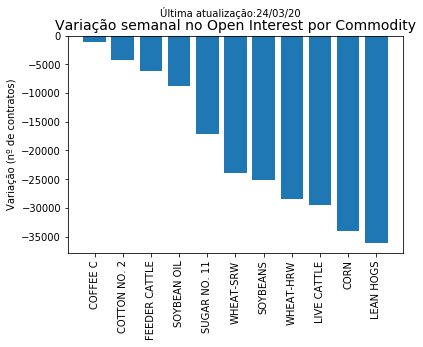

In [66]:
fig, ax = plt.subplots()
ax.bar(open_interest['Commodity'], height = open_interest['Change_Open_Interest_All'])
ax.set_ylabel('Variação (nº de contratos)')
#plt.grid(True,'major','y', ls = '--')
plt.title('Variação semanal no Open Interest por Commodity', fontsize = 14)
plt.suptitle('Última atualização:' + str(last_update.strftime('%d/%m/%y')), fontsize = 10)
plt.xticks(rotation=90)
plt.show() 

No gráfico acima, houve grande redução dos contratos em aberto, provavelmente por conta da busca por liquidez gerada pelo coronavírus e expectativa de recessão.

#### 3.3. Composição do Open Interest

O Open Interest é composto pela posição dos diferentes players do mercado. Cada Open Interest, ou "contrato em aberto" é equivalente a dois contratos: um na posição vendida e um na posição comprada. Quando um novo negócio é feito, abre-se um novo contrato, e quando a posição é encerrada, o mesmo ocorre com o contrato. Portanto, o **total** de posições vendidas deve ser igual ao total das posições compradas, ambas somadas ao 'spreading', que é uma operação de compra e venda simultânea. Porém, quem faz a compra ou  venda no mercado não necessariamente está classificado da mesma forma. O mercado analisa justamente essa diferença entre classes, e a partir dela pode-se saber o quanto uma safra está precificada ou se fundos especuladores estão com uma visão mais otimista ou pessimista do mercado.

"Commercials", por exemplo, é a classificação dada aos players do mercado que estão envolvidos com a commodity física. Eles utilizam a bolsa para precificar sua produção e fechar negócios futuros. Normalmente são esses players que chegam no vencimento com alguma posição e recebem ou entregam a commodity  no porto. A bolsa faz a especificação dos locais e alocação entre as partes. Uma entrega atípica, como um produtor receber a commodity, pode indicar alguma mudança na dinâmica do mercado.

Como exemplo, será analisada a commodity Sugar No. 11, que são contratos de Açúcar bruto VHP:

In [68]:
mask = (df['Commodity'] == 'SUGAR NO. 11')&(df['date'] == last_update)

In [313]:
sugar = df.iloc[:,5:17][mask]

In [314]:
sugar.head()

,Open_Interest_All,NComm_Positions_Long_All_NoCIT,NComm_Positions_Short_All_NoCIT,NComm_Postions_Spread_All_NoCIT,Comm_Positions_Long_All_NoCIT,Comm_Positions_Short_All_NoCIT,Tot_Rept_Positions_Long_All,Tot_Rept_Positions_Short_All,NonRept_Positions_Long_All,NonRept_Positions_Short_All,CIT_Positions_Long_All,CIT_Positions_Short_All
132,"1,255,442.0","78,818.0","88,715.0","254,158.0","547,987.0","772,477.0","1,181,266.0","1,188,995.0","74,177.0","66,448.0","300,303.0","73,646.0"


In [383]:
colunas = sugar[sugar.columns[sugar.columns.str.contains('Long')]].columns.str.split('_', n=1)

In [384]:
index = []
for linha in colunas:
    index.append(linha[0]) 

In [390]:
index.append('Spread')

In [392]:
index

['NComm', 'Comm', 'Tot', 'NonRept', 'CIT', 'Spread']

In [393]:
long = sugar[sugar.columns[sugar.columns.str.contains('Long')]].values[0]

In [394]:
short = sugar[sugar.columns[sugar.columns.str.contains('Short')]].values[0]

In [395]:
spread = sugar[sugar.columns[sugar.columns.str.contains('Spread')]].values[0][0]

In [396]:
total = sugar['Open_Interest_All'].values[0]

In [398]:
dados = {'Total':np.append(total,np.zeros(5)),'Long':np.append(long,spread),'Short':np.append(short,spread)}

In [399]:
dados

{'Total': array([1255442.,       0.,       0.,       0.,       0.,       0.]),
 'Long': array([  78818.,  547987., 1181266.,   74177.,  300303.,  254158.]),
 'Short': array([  88715.,  772477., 1188995.,   66448.,   73646.,  254158.])}

In [400]:
graf = pd.DataFrame(data = dados, index = index)

In [403]:
graf.drop('Tot', inplace = True)

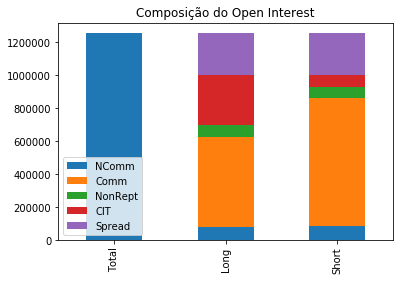

In [410]:
graf.T.plot(kind = 'bar',stacked = True)
plt.title('Composição do Open Interest')
plt.legend(loc = 'lower left')

No gráfico acima, a posição dos "Commercials" é mais vendida (short) do que comprada (long). Isso é esperado, pois produtores de açúcar, devido ao seu porte financeiro, normalmente precificam com muito mais antecedência do que os clientes: fábricas e refinarias. Além disso, pode-se ver claramente que o Open Interest total é igual à soma dos contratos nas classes tanto no Long, como no Short.

#### 3.4. Posição líquida dos fundos

O mercado analisa semanalmente a posição de players especulativos (non-commercials + non-reportables), que essencialmente dão liquidez ao mercado. Uma posição mais vendida do que comprada, normalmente indica um sentimento bearish (baixista), enquanto a posição comprada indica uma posição altista (bullish). Além disso, exageros nessa posição são precursores no aumento da volatilidade e grandes movimentações no preço da commodity em questão.

Inicialmente calcula-se a posição líquida de cada player:

In [29]:
def net_short(df,col_name,col_long, col_short):
    df[col_name] = df[col_long] - df[col_short]

In [30]:
net_short(df,'Net_Non_Commercial','NComm_Positions_Long_All_NoCIT','NComm_Positions_Short_All_NoCIT')
net_short(df,'Net_Commercial','Comm_Positions_Long_All_NoCIT','Comm_Positions_Short_All_NoCIT')
net_short(df,'Net_Non_Rept','NonRept_Positions_Long_All','NonRept_Positions_Short_All')

 - A posição final é a soma da posição dos non-commercials com os non-reportables. A seguir, a posição reportada na última semana.

In [31]:
df['Net_COT'] = df['Net_Non_Commercial'] + df['Net_Non_Rept']

In [32]:
cot = df[['Commodity','Net_COT']][df['date'] == last_update].sort_values('Net_COT').set_index('Commodity')

In [33]:
pd.options.display.float_format = '{:,}'.format #divisão dos milhares para facilitar a visualização

In [34]:
cot #valor mais recente da posição em aberto dos fundos para cada commodity

,Net_COT
Commodity,
CORN,"-130,097.0"
COTTON NO. 2,"-22,688.0"
WHEAT-SRW,"-21,574.0"
LIVE CATTLE,"-19,305.0"
WHEAT-HRW,"-18,126.0"
SOYBEAN OIL,"-10,317.0"
FEEDER CATTLE,"-9,932.0"
SOYBEANS,"-3,137.0"
SUGAR NO. 11,"-2,168.0"


- Além da posição mais recente, pode-se analisar também como esse número variou ao longo do tempo:

In [35]:
def graph_by_cmdty(df,title):
    cmdty = df['Commodity'].unique()
    nrow = 3
    ncol = 4
    df_list = []
    for c in cmdty:
        mask = df['Commodity'] == c
        temp = df.loc[:,['Net_COT','date']][mask].copy()
        temp.sort_values('date', inplace = True)
        temp.set_index(pd.DatetimeIndex(temp['date']), inplace = True)
        temp.drop('date', axis = 1, inplace = True)
        df_list.append(temp)
    
    fig, axes = plt.subplots(nrow, ncol, figsize=(20,10), sharex = 'col')
    count = 0
    for r in range(nrow):
        for c in range(ncol):
            df_list[count].plot(ax=axes[r,c], kind = 'bar', title = cmdty[count], legend = False)
            count +=1
            if count == len(cmdty):
                count = 10

    ax = plt.subplot(3,4,12)
    ax.axis('off')
    plt.suptitle(title, fontsize = 16)
    plt.show()
    
    #formatar eixo da data
    
    #myFmt = mdates.DateFormatter('%d-%m-y')           
    #plt.xticks(myFmt) 
    #plt.xticks(rotation=90)
    #fig.autofmt_xdate(which = 'major')

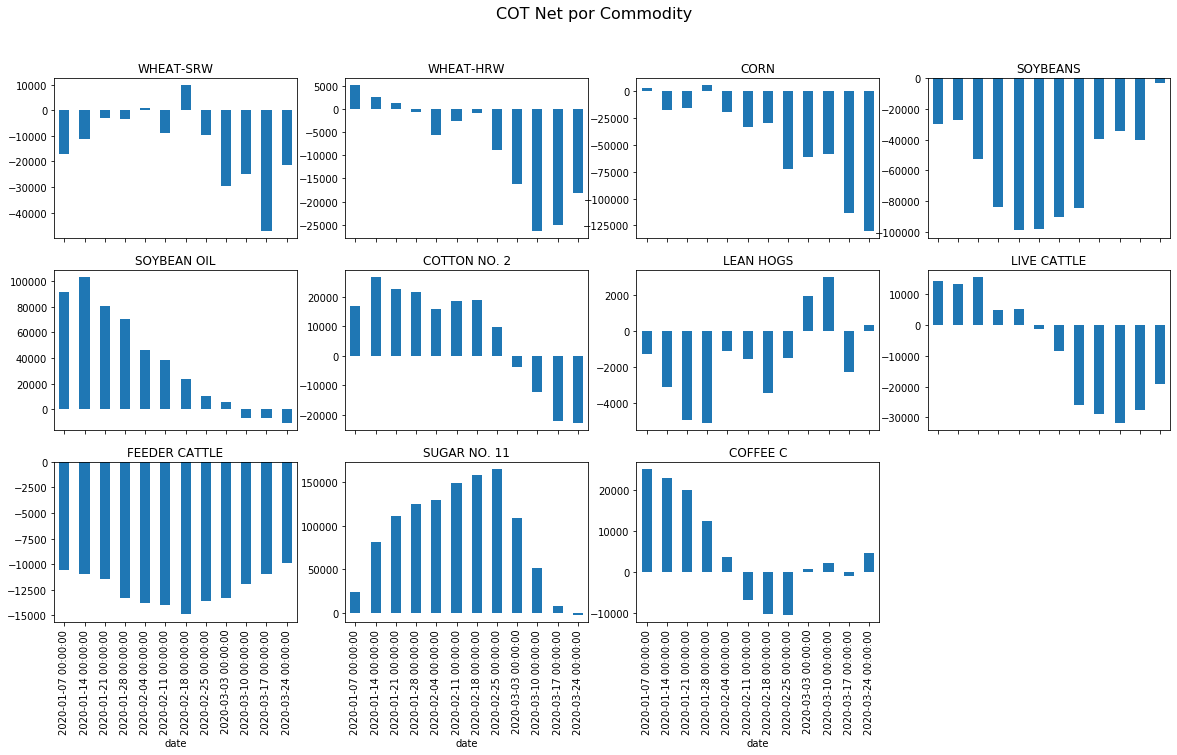

In [36]:
graph_by_cmdty(df,'COT Net por Commodity')

Nos gráficos acima, observa-se a redução ou inversão das posições "net long" ou "net short" a partir do início de março, coincidindo com a explosão do coronavírus fora da China e aumentando a volatilidade nos mercados.

## 4. Conclusão

Foi feita a análise da base de dados históricos consolidada do CFTC. Observou-se a distribuição e composição do Open Interest, assim como a posição em aberto líquida para cada commodity e sua evolução semanal.

### Próximos passos:

- Analisar a posição vendida dos "Commercials" por vencimento de tela, o que é um indicativo do quanto a safra estaria precificada no caso dos produtores.
- Analisar separadamente o Open interest de futuros e opções, também considerando o vencimento.
- Obter dados de preços do mercado por algum API ([barchart](https://www.barchart.com), por exemplo) e avaliar a correlação com as variáveis analisadas no relatório